In [7]:
import torch
import torchvision
from torchvision.datasets import MNIST

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Download training dataset
dataset = MNIST(root='data/', download=False)

In [9]:
len(dataset)

60000

In [10]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Label: 9


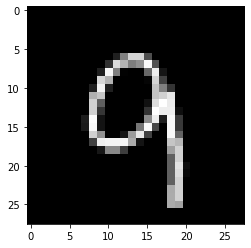

In [14]:
image, label = dataset[np.random.randint(0, len(dataset))]
plt.imshow(image, cmap='gray')
print('Label:', label)

PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [15]:
import torchvision.transforms as transforms

# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [16]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


##### Train and validation sets
Split the dataset in train, validation and test

In [18]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)
print(train_ds)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [19]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

###### Logistic regression
The model is linear so it expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [26]:
import torch.nn as nn



# Logistic regression model
class MnistModel(nn.Module):

    def __init__(self):
        self.input_size = 28*28
        self.num_classes = 10
        super().__init__()
        self.linear = nn.Linear(self.input_size, self.num_classes)
        
    def forward(self, xb):
        print(f"Before: {xb.shape}")
        xb = xb.reshape(-1, self.input_size)
        print(f"After: {xb.shape}")
        out = self.linear(xb)
        return out
    
model = MnistModel()
model

MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [27]:
model.parameters

<bound method Module.parameters of MnistModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)>

In [28]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs for the first two images :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
Before: torch.Size([128, 1, 28, 28])
After: torch.Size([128, 784])
outputs.shape :  torch.Size([128, 10])
Sample outputs for the first two images :
 tensor([[-0.1065,  0.4206, -0.2280,  0.1592,  0.2773, -0.0869,  0.1725,  0.2119,
         -0.1351, -0.0100],
        [-0.1561,  0.1792, -0.4197, -0.0732,  0.2789, -0.2484, -0.0062, -0.0748,
         -0.0298,  0.2610]])


We want to turn the output to probabilities. We can do this first exponentiating and then normalizing
$$S(y_i) = \frac{e^{y_i}}{\sum_je^{y_j}}$$

We apply softmax to *dim=1*. Note that dim 0 are the batches 128, while dim 1 are the 10 classes

In [64]:
import torch.nn.functional as F
# Apply softmax for each output row
print(outputs.shape)
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

torch.Size([128, 10])
Sample probabilities:
 tensor([[0.1002, 0.1115, 0.0815, 0.1113, 0.1093, 0.0849, 0.0849, 0.1177, 0.1010,
         0.0978],
        [0.0936, 0.0904, 0.0978, 0.0997, 0.1021, 0.1213, 0.0869, 0.1126, 0.1057,
         0.0899]])
Sum:  0.9999998807907104


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [65]:
max_probs, preds = torch.max(probs, dim=1)
print(f"predictions: \n{preds}")
print(f"probability: \n{max_probs}")

predictions: 
tensor([7, 5, 1, 5, 7, 4, 7, 4, 1, 3, 4, 5, 2, 7, 9, 5, 2, 8, 3, 5, 8, 3, 4, 4,
        1, 7, 4, 3, 4, 4, 8, 7, 2, 3, 2, 1, 5, 9, 5, 4, 7, 1, 4, 7, 0, 7, 1, 7,
        7, 4, 3, 3, 3, 5, 7, 1, 5, 4, 2, 0, 3, 1, 3, 1, 8, 7, 8, 2, 5, 4, 7, 6,
        8, 3, 6, 0, 4, 5, 3, 3, 1, 2, 1, 8, 7, 7, 2, 8, 1, 4, 3, 7, 4, 4, 4, 4,
        7, 5, 3, 7, 2, 5, 4, 3, 3, 7, 7, 2, 8, 1, 1, 4, 2, 5, 2, 7, 9, 5, 4, 9,
        2, 7, 2, 9, 8, 7, 7, 2])
probability: 
tensor([0.1177, 0.1213, 0.1246, 0.1126, 0.1150, 0.1500, 0.1411, 0.1151, 0.1247,
        0.1310, 0.1225, 0.1435, 0.1154, 0.1212, 0.1167, 0.1303, 0.1212, 0.1289,
        0.1276, 0.1198, 0.1316, 0.1235, 0.1251, 0.1309, 0.1340, 0.1423, 0.1260,
        0.1207, 0.1239, 0.1431, 0.1189, 0.1143, 0.1224, 0.1244, 0.1346, 0.1217,
        0.1114, 0.1122, 0.1155, 0.1334, 0.1362, 0.1348, 0.1131, 0.1401, 0.1172,
        0.1370, 0.1265, 0.1237, 0.1283, 0.1134, 0.1322, 0.1154, 0.1215, 0.1398,
        0.1286, 0.1211, 0.1197, 0.1348, 0.1285, 0.1208, 0.1

We can define an accuracy function counting the number of predictions == actual labels.

The == operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing True for unequal elements and False for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because e^x is an increasing function, i.e., if y1 > y2, then e^y1 > e^y2. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data.

In [29]:
# count percentage of correctly classified samples
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
accuracy(outputs, labels)
# the accuracy is around 1/10. 
# This is not supring since the weights are randomly initialized

tensor(0.1250)

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

For these reasons, accuracy is often used as an evaluation metric for classification, but not as a loss function. A commonly used loss function for classification problems is the cross-entropy, which has the following formula:

<img src="https://i.imgur.com/VDRDl1D.png">

Note that only the value $i$ s.t. $y_i=1$ is kept

In [68]:
loss_fn = F.cross_entropy

# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2924, grad_fn=<NllLossBackward>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. The lower the loss, The better the model. 

##### Training the model

In [71]:
input_size = 784
num_classes = 10
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [72]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [73]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [77]:
history1 = fit(50, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7358, val_acc: 0.8433
Epoch [1], val_loss: 0.7181, val_acc: 0.8457
Epoch [2], val_loss: 0.7021, val_acc: 0.8481
Epoch [3], val_loss: 0.6876, val_acc: 0.8497
Epoch [4], val_loss: 0.6742, val_acc: 0.8514
Epoch [5], val_loss: 0.6619, val_acc: 0.8524
Epoch [6], val_loss: 0.6506, val_acc: 0.8538
Epoch [7], val_loss: 0.6401, val_acc: 0.8549
Epoch [8], val_loss: 0.6303, val_acc: 0.8569
Epoch [9], val_loss: 0.6212, val_acc: 0.8573
Epoch [10], val_loss: 0.6127, val_acc: 0.8584
Epoch [11], val_loss: 0.6047, val_acc: 0.8601
Epoch [12], val_loss: 0.5972, val_acc: 0.8616
Epoch [13], val_loss: 0.5901, val_acc: 0.8623
Epoch [14], val_loss: 0.5835, val_acc: 0.8631
Epoch [15], val_loss: 0.5771, val_acc: 0.8637
Epoch [16], val_loss: 0.5712, val_acc: 0.8645
Epoch [17], val_loss: 0.5655, val_acc: 0.8656
Epoch [18], val_loss: 0.5601, val_acc: 0.8662
Epoch [19], val_loss: 0.5550, val_acc: 0.8668
Epoch [20], val_loss: 0.5501, val_acc: 0.8671
Epoch [21], val_loss: 0.5455, val_acc: 0.867

In [115]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size)

evaluate(model, test_loader)    

{'val_loss': 0.4357922673225403, 'val_acc': 0.8885482549667358}

In [81]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 6 , Predicted: 6


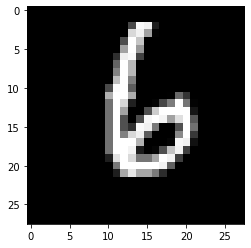

In [113]:
import numpy as np
img, label = test_dataset[np.random.randint(len(test_dataset))]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 3


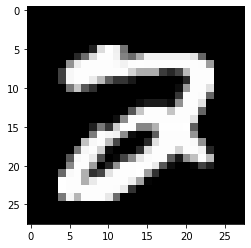

In [114]:
# Wrong
while True:
    img, label = test_dataset[np.random.randint(len(test_dataset))]
    if label != predict_image(img, model):
        break
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

###### Save/Load model

In [117]:
# Save state of the model
torch.save(model.state_dict(), 'mnist-logistic.pth')

# Instantiate new object
model2 = MnistModel()
result = evaluate(model2, test_loader)
print(f"New instatiated model {result}")

# Load model
model2.load_state_dict(torch.load('mnist-logistic.pth'))

test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

New instatiated model {'val_loss': 2.3092503547668457, 'val_acc': 0.06416015326976776}


{'val_loss': 0.43419450521469116, 'val_acc': 0.8875976800918579}